# 1 часть: Линейные модели

In [484]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import numpy as np
import math

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

load_diabetes - игрушечный набор данных 442 пациентов с диабетом.

Информация о признаках

1. Возраст 
2. Пол пациента
3. Индекс массы тела bmi
4. среднее артериальное давление bp
5. s1 общий холестерин сыворотки
6. s2 липопротеины низкой плотности
7. s3 липопротеины высокой плотности
8. s4 общий холестерин / ЛПВП
9. s5 логарифм уровня триглицеридов в сыворотке
10. s6 уровень сахара в крови

Столбец 11 представляет собой количественный показатель прогрессирования заболевания через год после исходного уровня.

In [485]:
my_data = load_diabetes()

df = pd.DataFrame(columns = my_data['feature_names'], data = my_data['data'])
df['target'] = my_data['target']

df.head()

age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4 -0.002592 -0.031988 -0.046641   135.0

Отрисуем зависимость индекса массы тела и показателя прогрессирования заболевания.

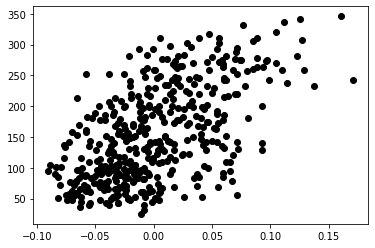

In [486]:
X = df.bmi
y = df.target

plt.scatter(X, y, color="black")
plt.show()

## 1.1: Метод наименьших квадратов (Линейная регрессия)
Параметры LinearRegression:
1. fit_intercept - Рассчитывать ли intercept для этой модели. Если установлено значение False, то ожидается, что данные будут центрированы.
2. copy_X - Если True, X будет скопирован; в противном случае он может быть перезаписан.
3. n_jobs - Количество ядер, используемых для вычисления. Это обеспечит ускорение только в случае достаточно большого объема данных.
4. positive - Если установлено значение True, коэффициенты будут положительными.

Обучим модель и отрисуем среди множества точек

In [487]:
regr = LinearRegression()

regr.fit(X.values.reshape(-1, 1), y)

LinearRegression()

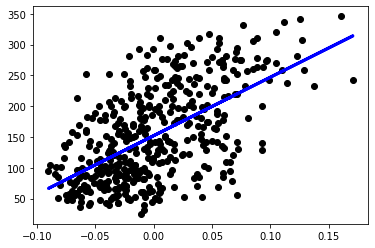

In [488]:
plt.scatter(X, y, color="black")
plt.plot(X, regr.predict(X.values.reshape(-1, 1)), color="blue", linewidth=3)
plt.show()

Можно посмотреть коэффициенты модели и ее intercept

In [489]:
regr.coef_

array([949.43526038])

In [490]:
regr.intercept_

152.13348416289617

Так же измерим качество нашей модели с помощью MSE, MAE и R2:

In [491]:
print(mean_squared_error(y, regr.predict(X.values.reshape(-1, 1))))
print(mean_absolute_error(y, regr.predict(X.values.reshape(-1, 1))))
print(r2_score(y, regr.predict(X.values.reshape(-1, 1))))

3890.456585461273
51.798627639533656
0.3439237602253802


Добавим новую переменную, отрисуем точки, а также построим регрессионную модель.

In [492]:
X = df[['bmi', 's6']]
y = df.target

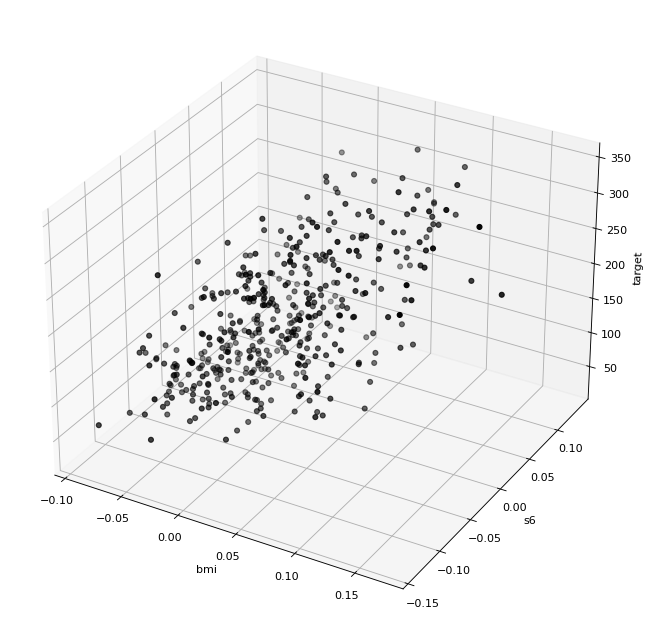

In [493]:
ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['bmi'], X['s6'], y, color="black")

ax.set_xlabel('bmi')
ax.set_ylabel('s6')
ax.set_zlabel('target')

plt.show()

In [494]:
regr = LinearRegression()

regr.fit(X, y)

LinearRegression()

В данном примере наша модель будет представлять собой плоскость 

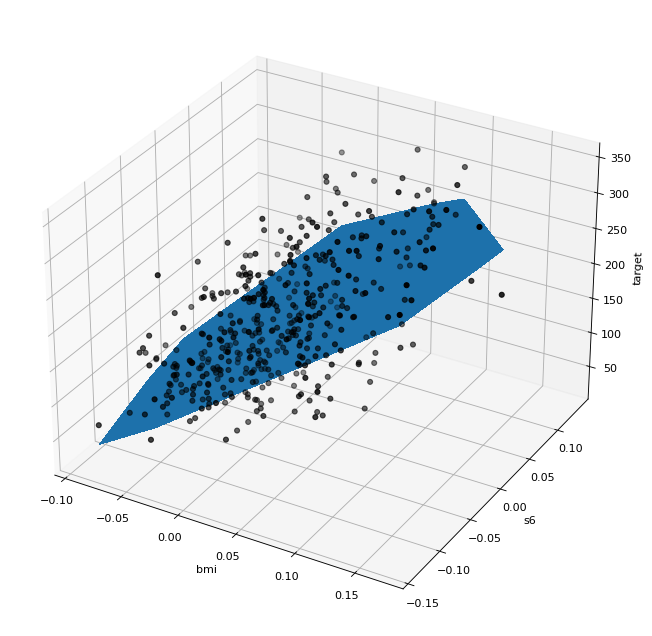

In [495]:
ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['bmi'], X['s6'], y, color="black")

ax.plot_trisurf(X['bmi'], X['s6'], regr.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('bmi')
ax.set_ylabel('s6')
ax.set_zlabel('target')

plt.show()

Заметим, что с двумя предикторами ошибка стала меньше, а R2 стал больше.

In [496]:
print(mean_squared_error(y, regr.predict(X)))
print(mean_absolute_error(y, regr.predict(X)))
print(r2_score(y, regr.predict(X)))

3723.6286362544433
51.01325352589804
0.3720571813806123


## 1.2: Регрессия и классификация методом Ридж
### 1.2.1: Регрессия

Продолжим рассмотрение задачи с диабетом, выберем два таких признака, между которыми наблюдается наибольшая корреляция.

In [497]:
X = df[['s1', 's2']]
y = df.target

Корелляция положительна и равна 0.90, что означает следующее: с увеличением **s1**, будет так же увеличиваться **s2**

In [498]:
X.corr()

s1        s2
s1  1.000000  0.896663
s2  0.896663  1.000000

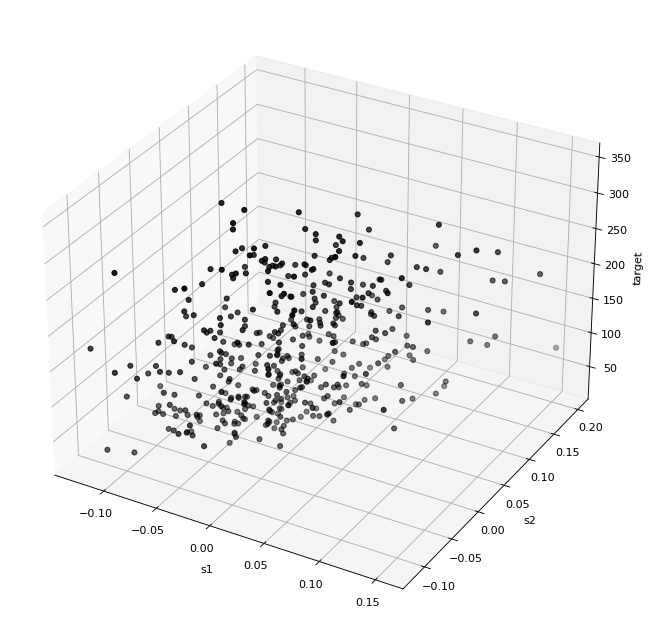

In [499]:
ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

Построим регрессионую модель 

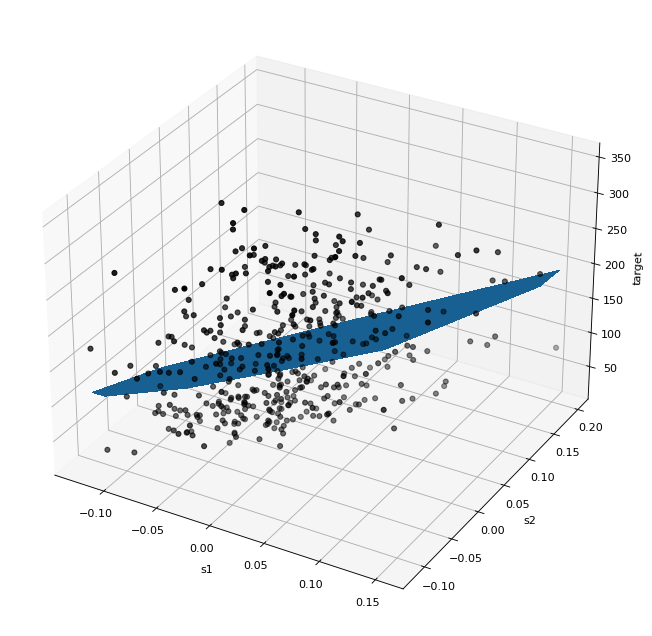

In [500]:
regr = LinearRegression()

regr.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")

#ax.plot(X['bmi'], X['s6'], regr.predict(X), color="blue", linewidth=3)
ax.plot_trisurf(X['s1'], X['s2'], regr.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

Обычная линейная регрессия имеет коэффициенты 462.20 и -132.65, что означает следующее: наибольшее значение таргета будет достигаться при наибольшем значении s1 и наименьшем значении s2.
Несмотря на то, что предсказаниям такой модели можно доверять, то анализу взаимосвязи между предикторами и предсказанным значениям в условиях мультиколлинеарности доверять нельзя.

In [501]:
print(regr.intercept_, regr.coef_)
print(mean_squared_error(y, regr.predict(X)))
print(mean_absolute_error(y, regr.predict(X)))
print(r2_score(y, regr.predict(X)))

152.13348416289594 [ 462.19748116 -132.6507672 ]
5655.51294992535
63.64066234006419
0.04626935459202375


Уравнение Ridge регрессии отличается от метода наименьших квадратов наличием дополнительных штрафов (L2 регуляризация), которые позволяют бороться с проблемой мультиколлинеарности.
Параметры Ridge:
1. alpha - Константа, умножающая член L2, контролирующая силу регуляризации в [0, inf).
2. fit_intercept - Рассчитывать ли intercept для этой модели. Если установлено значение False, то ожидается, что данные будут центрированы.
3. copy_X - Если True, X будет скопирован; в противном случае он может быть перезаписан.
4. max_iter - Максимальное число итераций для алгоритма градиентного спуска.
5. tol - Шаг градиентного спуска.
6. positive - Если установлено значение True, коэффициенты будут положительными.
7. А также параметры отвечающие за алгоритм вычисления описаны подробнее тут: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge

Обучим модель и отрисуем среди множества точек

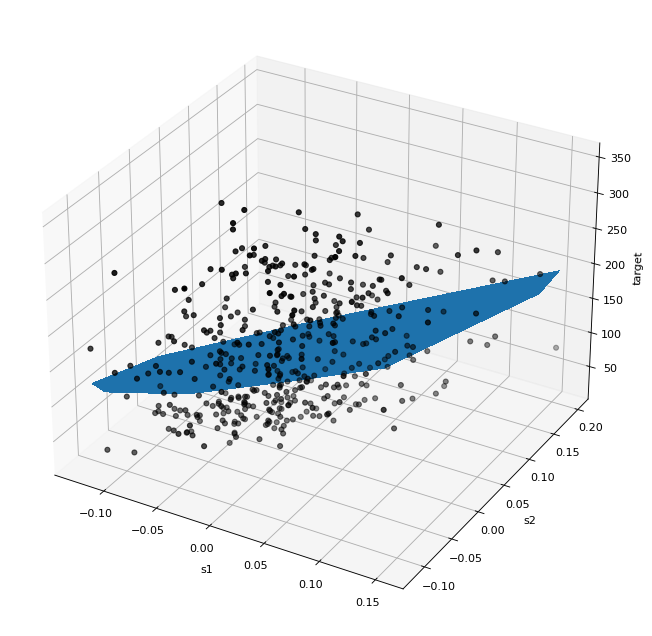

In [502]:
ridg = Ridge(alpha=.5)

ridg.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")

ax.plot_trisurf(X['s1'], X['s2'], ridg.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

Несмотря на более низкий R2 чем в случае с МНК, коэффициент при s2 приобрел положительное значение.

In [503]:
print(ridg.intercept_, ridg.coef_)
print(mean_squared_error(y, ridg.predict(X)))
print(mean_absolute_error(y, ridg.predict(X)))
print(r2_score(y, ridg.predict(X)))

152.13348416289594 [181.33933586  79.45621873]
5694.062056793101
64.1465287651931
0.039768535851370634


###  1.2.2: Классификация

In [696]:
from sklearn.datasets import load_iris
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split

Рассмотрим задачу классификации на примере набора данных цветов Ириса.
Информация о признаках
1. Длина наружной доли околоцветника (англ. sepal length);
2. Ширина наружной доли околоцветника (англ. sepal width);
3. Длина внутренней доли околоцветника (англ. petal length);
4. Ширина внутренней доли околоцветника (англ. petal width).

Таргет представляет собой вид Ириса (подробнее https://ru.wikipedia.org/wiki/Ирисы_Фишера)


In [697]:
iris = load_iris()

df_iris = pd.DataFrame(columns = iris['feature_names'], data = iris['data'])
df_iris['target'] = iris['target']

df_iris.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0

Разобьем выборку на обучающую и тестовую (2:1)

In [510]:
X = df_iris.iloc[:, :-1]
y = df_iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Отрисуем первые 3 признака на графике, а таргет пометим цветом.

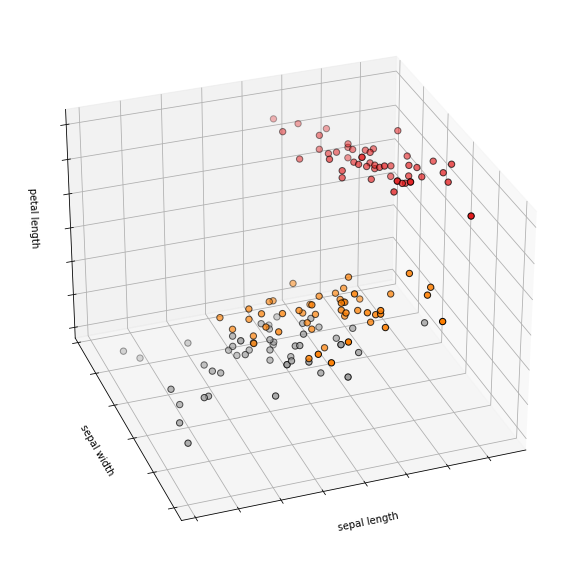

In [511]:
fig = plt.figure(1, figsize=(10, 30))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

ax.scatter(
    df_iris.iloc[:, 0],
    df_iris.iloc[:, 1],
    df_iris.iloc[:, 2],
    c=df_iris.target,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

ax.set_xlabel("sepal length")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("sepal width")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("petal length")
ax.zaxis.set_ticklabels([])

plt.show()

В качестве модели будем использовать RidgeClassifier, который имеет почти такие же параметры как и Ridge:
    
1. alpha - Константа, умножающая член L2, контролирующая силу регуляризации в [0, inf).
2. fit_intercept - Рассчитывать ли intercept для этой модели. Если установлено значение False, то ожидается, что данные будут центрированы.
3. copy_X - Если True, X будет скопирован; в противном случае он может быть перезаписан.
4. max_iter - Максимальное число итераций для алгоритма градиентного спуска.
5. tol - Шаг градиентного спуска.
6. class_weight - Веса, связанные с классами в форме {метка_класса: вес}. Если не указано, предполагается, что все классы имеют вес один. «Сбалансированный» режим использует значения y для автоматической корректировки весов, обратно пропорциональных частотам классов во входных данных.
7. А также параметры отвечающие за алгоритм вычисления описаны подробнее тут: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html

In [512]:
ridg_clf = RidgeClassifier(alpha=0.5)

ridg_clf.fit(X_train, y_train)

RidgeClassifier(alpha=0.5)

В качестве оценки модели будем использовать матрицу ошибок.

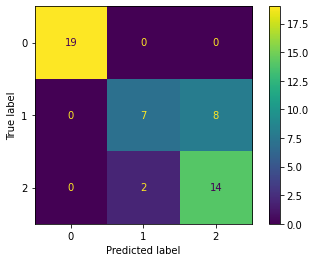

In [513]:
y_pred = ridg_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

Заметим, что наша модель хорошо распознает первый класс, но много экземпляров второго класса относит к третьему классу.

### 1.2.3: Регрессия c кросс-валидацией

RidgeCV представляет собой Ridge со встроенной кросс-валидацией, что позволяет найти значение штрафа alpha так, что значение R2 (по умолчанию) будет наилучшим.

Параметры RidgeCV:

1. alphas - Список штрафов alpha, среди которых выбирается наиболее подходящий
2. fit_intercept - Рассчитывать ли intercept для этой модели. Если установлено значение False, то ожидается, что данные будут центрированы.
3. scoring - Метрика, на которую будет опираться кросс-валидация
4. cv - Количество сплитов для кросс-валидации.
5. gcv_mode - Стратегия кросс-валидации.
6. А так же несколько других параметров тут https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html

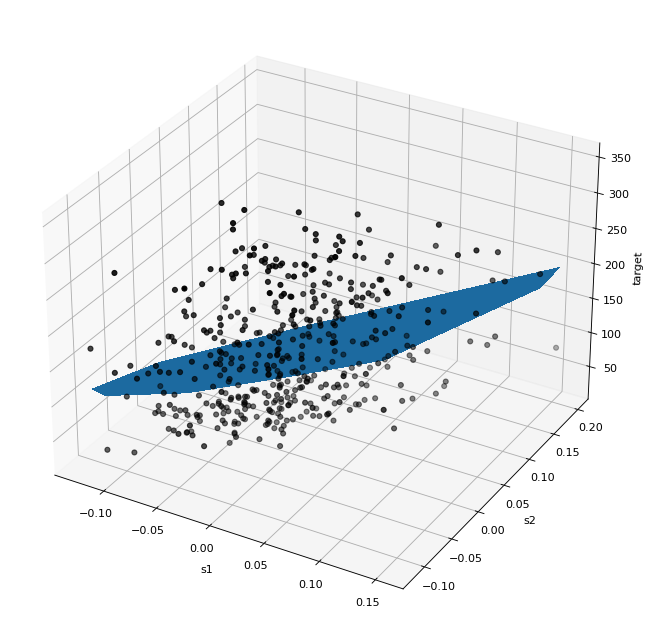

152.13348416289594 [307.67355254   5.36828699]
5666.101637748189
63.85528366895611
0.04448370647120503


In [514]:
from sklearn.linear_model import RidgeCV, RidgeClassifierCV

X = df[['s1', 's2']]
y = df.target

ridg = RidgeCV()

ridg.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")

#ax.plot(X['bmi'], X['s6'], regr.predict(X), color="blue", linewidth=3)
ax.plot_trisurf(X['s1'], X['s2'], ridg.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(ridg.intercept_, ridg.coef_)
print(mean_squared_error(y, ridg.predict(X)))
print(mean_absolute_error(y, ridg.predict(X)))
print(r2_score(y, ridg.predict(X)))

Обратим внимание на то, что метрики стали лучше, чем без кросс-валидации.

### 1.2.4: Классификация c кросс-валидацией

Подробнее о параметрах RidgeClassifierCV можно почитать тут:
    https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifierCV.html#sklearn.linear_model.RidgeClassifierCV

In [515]:
X = df_iris.iloc[:, :-1]
y = df_iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

ridg_clf = RidgeClassifierCV(alphas=[0.001, 0.1, 1.0, 5.0, 10.0, 20.0])

ridg_clf.fit(X_train, y_train)

RidgeClassifierCV(alphas=[0.001, 0.1, 1.0, 5.0, 10.0, 20.0])

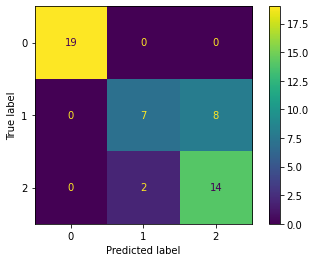

In [516]:
y_pred = ridg_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

В данном случае без изменений.

## 1.3: Регрессия методом Лассо
### 1.3.1: Регрессия

Метод Лассо это еще один подход в регуляризации (так называемая L1 регуляризация, которая позволяет моделям не переобучаться, а также бороться с мультиколлинеарностью). Данный подход так же основан на добавлении штрафов.

Параметры Lasso:
1. alpha - Константа, умножающая член L1, контролирующая силу регуляризации в [0, inf).
2. fit_intercept - Рассчитывать ли intercept для этой модели. Если установлено значение False, то ожидается, что данные будут центрированы.
3. copy_X - Если True, X будет скопирован; в противном случае он может быть перезаписан.
4. max_iter - Максимальное число итераций для алгоритма градиентного спуска.
5. tol - Шаг градиентного спуска.
6. positive - Если установлено значение True, коэффициенты будут положительными. 
7. Больше: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

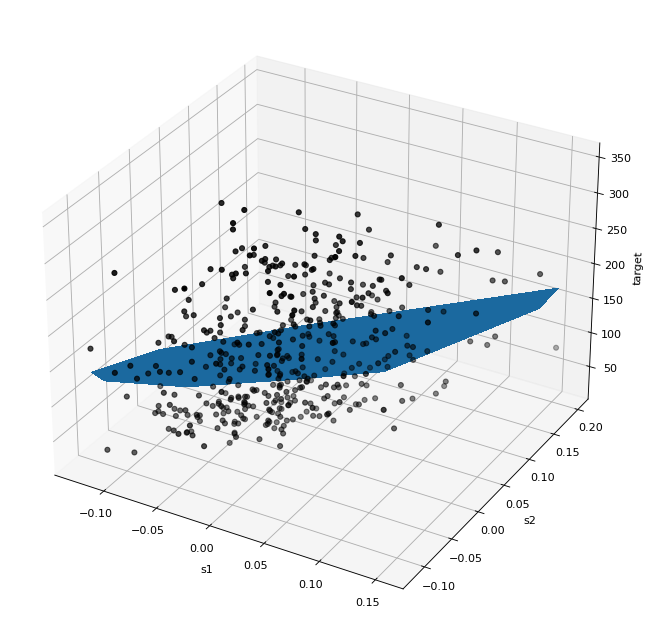

152.13348416289594 [122.25445189   0.        ]
5773.815623739355
64.78963866644146
0.02631910667479287


In [517]:
from sklearn.linear_model import Lasso, LassoCV

X = df[['s1', 's2']]
y = df.target

lasso = Lasso(alpha=.5)

lasso.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], lasso.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(lasso.intercept_, lasso.coef_)
print(mean_squared_error(y, lasso.predict(X)))
print(mean_absolute_error(y, lasso.predict(X)))
print(r2_score(y, lasso.predict(X)))

Особенностью данного метода, является зануление коэффициентов незначимых и сильно коррелирующих признаков.

### 1.3.2: Регрессия c кросс-валидацией

Аналогично методу из 1.2.3, подробнее тут: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV

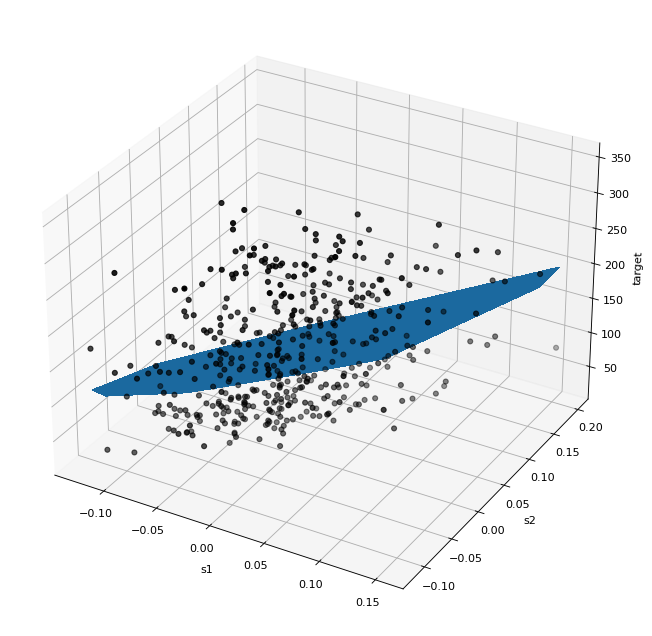

152.13348416289594 [320.67060105  -0.        ]
5664.469538487784
63.82212326617918
0.04475893934482389


In [518]:
X = df[['s1', 's2']]
y = df.target

lasso = LassoCV()

lasso.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], lasso.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(lasso.intercept_, lasso.coef_)
print(mean_squared_error(y, lasso.predict(X)))
print(mean_absolute_error(y, lasso.predict(X)))
print(r2_score(y, lasso.predict(X)))

Результат работы алгоритма повысил значение R2 по сравнению с методом без кросс-валидации.

## 1.4: Мультизадачное Лассо

В некоторых случаях, нам необходимо предсказать сразу несколько таргетов. 

Например: пусть имеются данные о пользователе который проходит определнный курс, необходимо определить за какой срок пользователь пройдет курс, а так же какую оценку он получит по окончанию курса.

### 1.4.1: Регрессия 

В качестве простейшего примера рассмотрим предсказание y=2x и y=x^2, по переменной x

In [726]:
from sklearn.linear_model import MultiTaskLasso, MultiTaskLassoCV

x = np.random.randint(40, size=1000)

kx_df = pd.DataFrame({
    'x': x,
    'y': x*2,
    'y^2': x**2
})

In [727]:
kx_df

x   y   y^2
0    38  76  1444
1    27  54   729
2    36  72  1296
3    22  44   484
4    14  28   196
..   ..  ..   ...
995  23  46   529
996   7  14    49
997  13  26   169
998   5  10    25
999  24  48   576

[1000 rows x 3 columns]

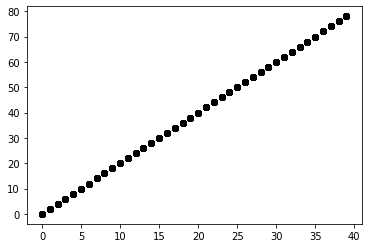

In [728]:
plt.scatter(kx_df.x, kx_df.y, color="black")
plt.show()

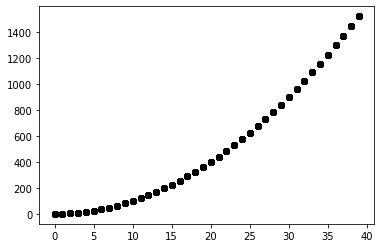

In [729]:
plt.scatter(kx_df.x, kx_df['y^2'], color="black")
plt.show()

Обучим наше Мультизадачное Лассо (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.MultiTaskLasso.html#sklearn.linear_model.MultiTaskLasso):

In [746]:
X = kx_df.x
y = kx_df[['y', 'y^2']]

lasso = MultiTaskLasso(alpha=.5)

lasso.fit(X.values.reshape(-1, 1), y)

MultiTaskLasso(alpha=0.5)

In [747]:
predict_y = lasso.predict(X.values.reshape(-1, 1))[:, 0]
predict_yy = lasso.predict(X.values.reshape(-1, 1))[:, 1]

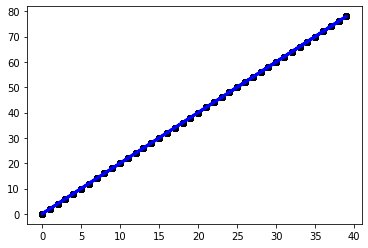

In [748]:
plt.scatter(kx_df.x, kx_df['y'], color="black")
plt.plot(kx_df.x, predict_y, color="blue", linewidth=3)
plt.show()

In [749]:
print(mean_squared_error(y[['y']], lasso.predict(X.values.reshape(-1, 1))[:, 0]))
print(mean_absolute_error(y[['y']], lasso.predict(X.values.reshape(-1, 1))[:, 0]))
print(r2_score(y[['y']], lasso.predict(X.values.reshape(-1, 1))[:, 0]))

4.762269330453616e-06
0.0019070250191058284
0.9999999911763249


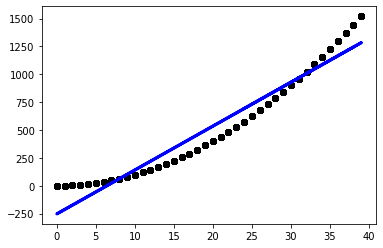

In [750]:
plt.scatter(kx_df.x, kx_df['y^2'], color="black")
plt.plot(kx_df.x, predict_yy, color="blue", linewidth=3)
plt.show()

In [751]:
print(lasso.intercept_, lasso.coef_)
print(mean_squared_error(y[['y^2']], lasso.predict(X.values.reshape(-1, 1))[:, 1]))
print(mean_absolute_error(y[['y^2']], lasso.predict(X.values.reshape(-1, 1))[:, 1]))
print(r2_score(y[['y^2']], lasso.predict(X.values.reshape(-1, 1))[:, 1]))

[ 3.70251907e-03 -2.53062750e+02] [[ 1.99981213]
 [39.39500457]]
13752.779476510153
100.21290091036707
0.9383827725650735


### 1.4.2: Регрессия с кросс-валидацией

Как и в случае с обычным Лассо, также есть метод с кросс-валидацией

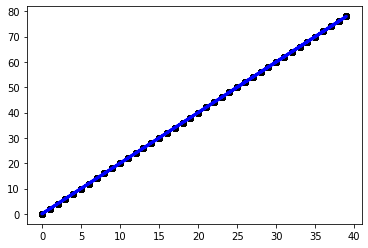

In [752]:
X = kx_df.x
y = kx_df[['y', 'y^2']]

lasso = MultiTaskLassoCV()

lasso.fit(X.values.reshape(-1, 1), y)

predict_y = lasso.predict(X.values.reshape(-1, 1))[:, 0]
predict_yy = lasso.predict(X.values.reshape(-1, 1))[:, 1]

plt.scatter(kx_df.x, kx_df['y'], color="black")
plt.plot(kx_df.x, predict_y, color="blue", linewidth=3)
plt.show()

In [753]:
print(mean_squared_error(y[['y']], lasso.predict(X.values.reshape(-1, 1))[:, 0]))
print(mean_absolute_error(y[['y']], lasso.predict(X.values.reshape(-1, 1))[:, 0]))
print(r2_score(y[['y']], lasso.predict(X.values.reshape(-1, 1))[:, 0]))

0.000539714944000468
0.02030166400000907
0.999999


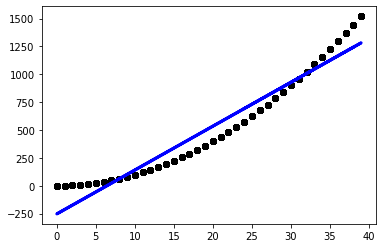

In [754]:
plt.scatter(kx_df.x, kx_df['y^2'], color="black")
plt.plot(kx_df.x, predict_yy, color="blue", linewidth=3)
plt.show()

Поскольку в данном примере всего один предиктор, то Лассо ведет себя как МНК. Также заметим, что связь y и x^2 не линейна, а значит использовать такую модель не очень хорошо. А так же обратим внимание на то, что наши признаки определены только в положительном пространстве, что так же не учитывается моделью.

In [755]:
print(lasso.intercept_, lasso.coef_)
print(mean_squared_error(y[['y^2']], lasso.predict(X.values.reshape(-1, 1))[:, 1]))
print(mean_absolute_error(y[['y^2']], lasso.predict(X.values.reshape(-1, 1))[:, 1]))
print(r2_score(y[['y^2']], lasso.predict(X.values.reshape(-1, 1))[:, 1]))

[ 3.94160000e-02 -2.52359218e+02] [[ 1.998     ]
 [39.35930676]]
13752.98707265131
100.19703166269954
0.9383818424622775


## 1.5: Эластичная сеть

In [757]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

### 1.5.1: Регрессия 

Эластичная сеть, это подход, который включает в себя как L1, так и L2 регуляризацию (http://www.machinelearning.ru/wiki/index.php?title=Эластичная_сеть).

Параметры ElasticNet:

Метод Эластик Нэт это еще один подход в регуляризации (так называемая L1 регуляризация, которая позволяет моделям не переобучаться, а также бороться с мультиколлинеарностью). Данный подход так же основан на добавлении штрафов.

Параметры Lasso:
1. alpha - Константа, умножающая член L1, контролирующая силу регуляризации в [0, inf).
2. l1_ratio - Параметр смешивания ElasticNet с 0 <= l1_ratio <= 1. Для l1_ratio = 0 штраф является штрафом L2. Для l1_ratio = 1 это штраф L1. Для 0 < l1_ratio < 1 штраф представляет собой комбинацию L1 и L2.
3. fit_intercept - Рассчитывать ли intercept для этой модели. Если установлено значение False, то ожидается, что данные будут центрированы.
4. copy_X - Если True, X будет скопирован; в противном случае он может быть перезаписан.
5. max_iter - Максимальное число итераций для алгоритма градиентного спуска.
6. tol - Шаг градиентного спуска.
7. positive - Если установлено значение True, коэффициенты будут положительными. 
8. Больше: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

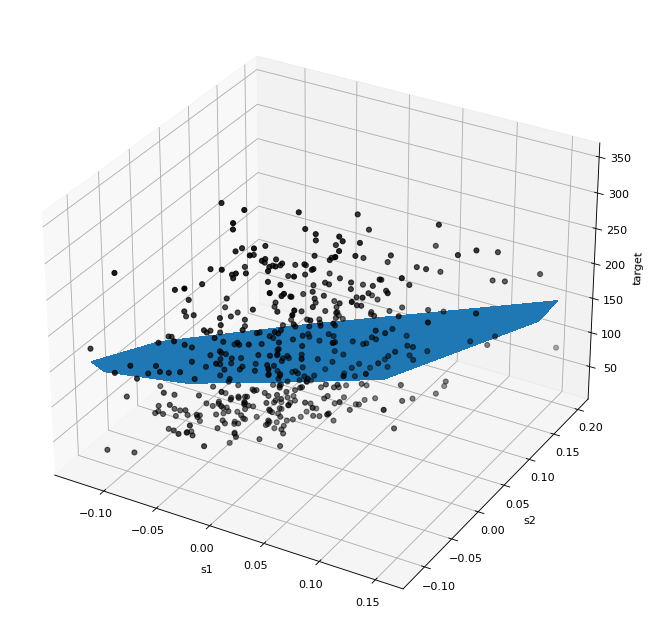

152.13348416289594 [2.07526436 1.51949579]
5924.7519605186235
65.73532190205378
0.0008656047260603428


In [758]:
X = df[['s1', 's2']]
y = df.target

elnet = ElasticNet(alpha=.5)

elnet.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], elnet.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(elnet.intercept_, elnet.coef_)
print(mean_squared_error(y, elnet.predict(X)))
print(mean_absolute_error(y, elnet.predict(X)))
print(r2_score(y, elnet.predict(X)))

### 1.5.2: Регрессия с кросс-валидацией

Аналог предыдущих моделей с кросс-валидацией, подробнее: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html

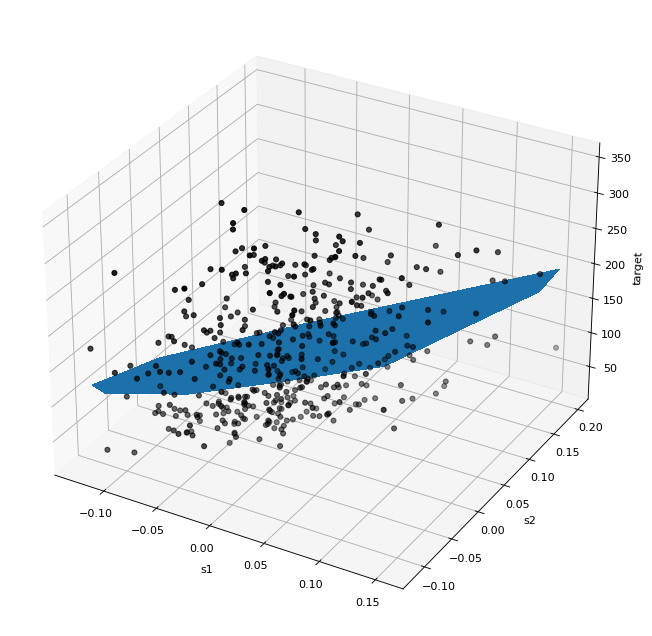

152.13348416289594 [208.20520332  70.53871686]
5685.483709464549
64.06410022520697
0.041215165504000395


In [759]:
X = df[['s1', 's2']]
y = df.target

elnet = ElasticNetCV()

elnet.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], elnet.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(elnet.intercept_, elnet.coef_)
print(mean_squared_error(y, elnet.predict(X)))
print(mean_absolute_error(y, elnet.predict(X)))
print(r2_score(y, elnet.predict(X)))

## 1.6: Мультизадачная Эластичная сеть

Еще один метод позволяющий решать сразу несколько задач регрессии.

Подробнее тут:
1. Без CV - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.MultiTaskElasticNet.html
2. C CV - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.MultiTaskElasticNetCV.html

### 1.6.1: Регрессия 

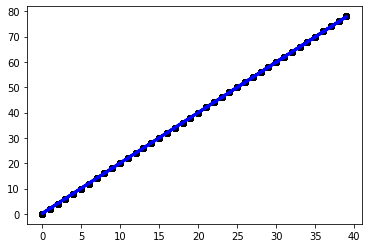

In [760]:
from sklearn.linear_model import MultiTaskElasticNet, MultiTaskElasticNetCV

X = kx_df.x
y = kx_df[['y', 'y^2']]

elnet = MultiTaskElasticNet()

elnet.fit(X.values.reshape(-1, 1), y)

predict_y = elnet.predict(X.values.reshape(-1, 1))[:, 0]
predict_yy = elnet.predict(X.values.reshape(-1, 1))[:, 1]

plt.scatter(kx_df.x, kx_df['y'], color="black")
plt.plot(kx_df.x, predict_y, color="blue", linewidth=3)
plt.show()

In [764]:
print(mean_squared_error(y[['y']], elnet.predict(X.values.reshape(-1, 1))[:, 0]))
print(mean_absolute_error(y[['y']], elnet.predict(X.values.reshape(-1, 1))[:, 0]))
print(r2_score(y[['y']], elnet.predict(X.values.reshape(-1, 1))[:, 0]))

0.0077343913970723994
0.07685329408485608
0.9999856694881566


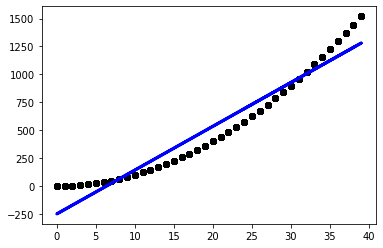

In [762]:
plt.scatter(kx_df.x, kx_df['y^2'], color="black")
plt.plot(kx_df.x, predict_yy, color="blue", linewidth=3)
plt.show()

In [763]:
print(elnet.intercept_, elnet.coef_)
print(mean_squared_error(y[['y^2']], elnet.predict(X.values.reshape(-1, 1))[:, 1]))
print(mean_absolute_error(y[['y^2']], elnet.predict(X.values.reshape(-1, 1))[:, 1]))
print(r2_score(y[['y^2']], elnet.predict(X.values.reshape(-1, 1))[:, 1]))

[ 1.49211879e-01 -2.50196310e+02] [[ 1.99242887]
 [39.24955905]]
13755.779071157474
100.14824397924733
0.9383693333395037


### 1.6.2: Регрессия с кросс-валидацией

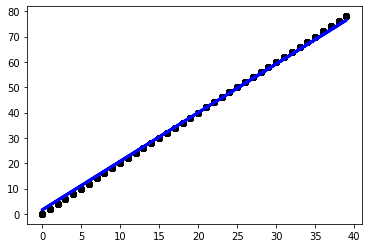

In [765]:
X = kx_df.x
y = kx_df[['y', 'y^2']]

elnet = MultiTaskElasticNetCV()

elnet.fit(X.values.reshape(-1, 1), y)

predict_y = elnet.predict(X.values.reshape(-1, 1))[:, 0]
predict_yy = elnet.predict(X.values.reshape(-1, 1))[:, 1]

plt.scatter(kx_df.x, kx_df['y'], color="black")
plt.plot(kx_df.x, predict_y, color="blue", linewidth=3)
plt.show()

In [766]:
print(mean_squared_error(y[['y']], elnet.predict(X.values.reshape(-1, 1))[:, 0]))
print(mean_absolute_error(y[['y']], elnet.predict(X.values.reshape(-1, 1))[:, 0]))
print(r2_score(y[['y']], elnet.predict(X.values.reshape(-1, 1))[:, 0]))

0.817302158889971
0.790024822835355
0.9984856781010496


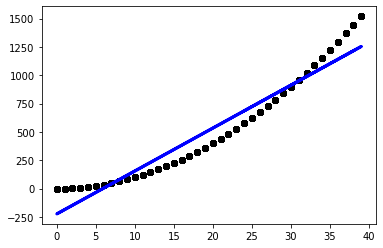

In [767]:
plt.scatter(kx_df.x, kx_df['y^2'], color="black")
plt.plot(kx_df.x, predict_yy, color="blue", linewidth=3)
plt.show()

In [768]:
print(elnet.intercept_, elnet.coef_)
print(mean_squared_error(y[['y^2']], elnet.predict(X.values.reshape(-1, 1))[:, 1]))
print(mean_absolute_error(y[['y^2']], elnet.predict(X.values.reshape(-1, 1))[:, 1]))
print(r2_score(y[['y^2']], elnet.predict(X.values.reshape(-1, 1))[:, 1]))

[   1.53384562 -222.91992133] [[ 1.92217142]
 [37.86553285]]
14069.94358046025
101.07488435275954
0.9369617672504266


## 1.7: Метод наименьших углов (LARS)

LARS решает следующую задачу. Пусть назначена линейная регрессионная модель. При большом количестве свободных переменных возникает проблема неустойчивого оценивания весов модели. LARS предлагает метод выбора такого набора свободных переменных, который имел бы наиболее значимую статистическую связь с зависимой переменной. Также LARS предлагает метод оценки весов.
Алгоритм LARS похож на алгоритм шаговой регрессии. Различие в том, что алгоритм LARS, вместо последовательного добавления свободных переменных, на каждом шаге изменяет их веса. Веса увеличиваются так, чтобы доставить наибольшую корреляцию с вектором регрессионных остатков. Основным достоинством LARS является то, что он выполняется за число шагов, не превышающее число свободных переменных. 

### 1.7.1: Регрессия 

Параметры меода Lars:
1. normalize - Этот параметр игнорируется, если для fit_intercept установлено значение False. Если True, регрессоры X будут нормализованы перед регрессией путем вычитания среднего значения и деления на l2-норму. Если вы хотите стандартизировать, используйте StandardScaler перед вызовом подгонки для оценки с normalize=False.
2. n_nonzero_coefs - Целевое количество ненулевых коэффициентов.
3. fit_intercept - Рассчитывать ли intercept для этой модели. Если установлено значение False, то ожидается, что данные будут центрированы.
4. copy_X - Если True, X будет скопирован; в противном случае он может быть перезаписан.
5. jitter - Верхняя граница параметра однородного шума, который необходимо добавить к значениям y, чтобы удовлетворить предположение модели о пошаговых вычислениях. Может помочь со стабильностью.
6. eps - Регуляризация с машинной точностью при вычислении диагональных факторов Холецкого. Увеличьте это для очень плохих систем. В отличие от параметра tol в некоторых итеративных алгоритмах оптимизации, этот параметр не управляет допуском оптимизации.
7. Больше: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lars.html

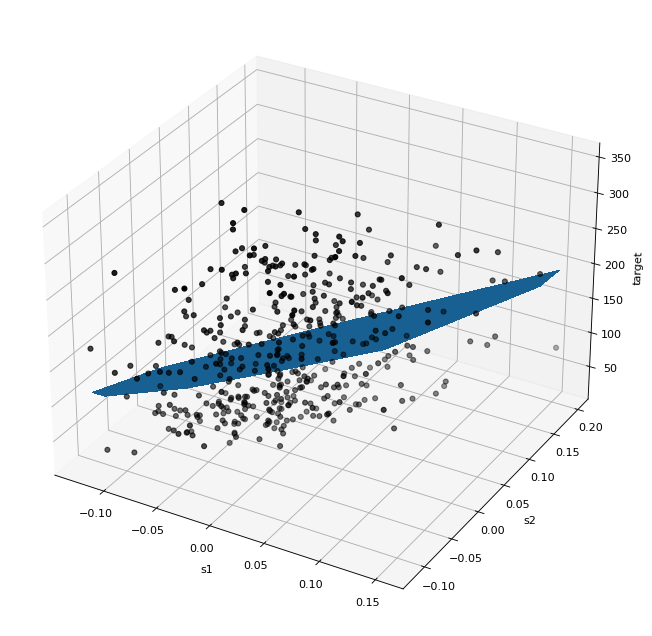

152.13348416289594 [ 462.19748116 -132.6507672 ]
5655.51294992535
63.64066234006419
0.04626935459202375


In [540]:
from sklearn.linear_model import Lars

X = df[['s1', 's2']]
y = df.target

lars = Lars(normalize=False)

lars.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], lars.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(lars.intercept_, lars.coef_)
print(mean_squared_error(y, lars.predict(X)))
print(mean_absolute_error(y, lars.predict(X)))
print(r2_score(y, lars.predict(X)))

### 1.7.2: Регрессия с кросс-валидацией

Поскольку LARS основан на итеративном переоснащении остатков, он может оказаться особенно чувствительным к воздействию шума. По этому был предложен метод LarsCV, который включает в себя кросс-валидацию опираясь на значение R2.

Более подробно о методе и его параметрах: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LarsCV.html

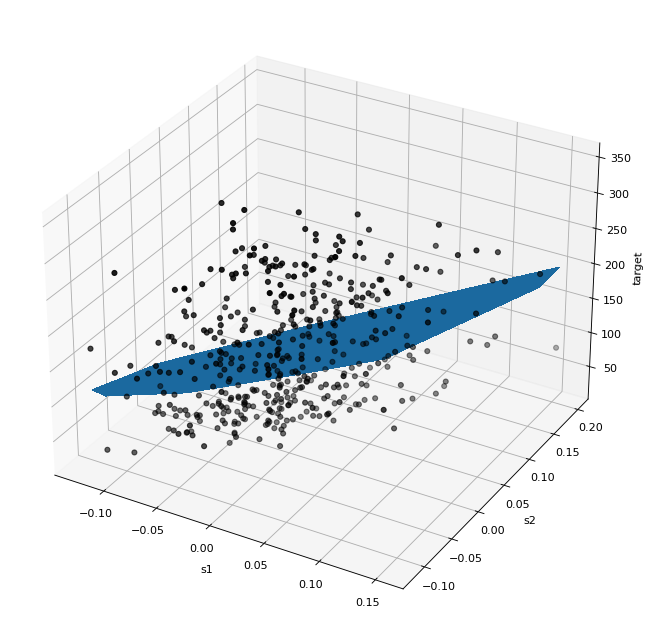

152.13348416289594 [320.06808718   0.        ]
5664.53193031968
63.82417290242349
0.044748417752418446


In [542]:
from sklearn.linear_model import LarsCV

X = df[['s1', 's2']]
y = df.target

lars = LarsCV(normalize=False)

lars.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], lars.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(lars.intercept_, lars.coef_)
print(mean_squared_error(y, lars.predict(X)))
print(mean_absolute_error(y, lars.predict(X)))
print(r2_score(y, lars.predict(X)))

## 1.8*: LARS Лассо

Так же есть подходы LassoLars, LassoLarsCV, LassoLarsIC.

Более подробно про каждый можно прочитать тут:
1. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLars.html
2. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLarsCV.html#sklearn.linear_model.LassoLarsCV
3. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLarsIC.html#sklearn.linear_model.LassoLarsIC

### 1.8.1: LassoLars

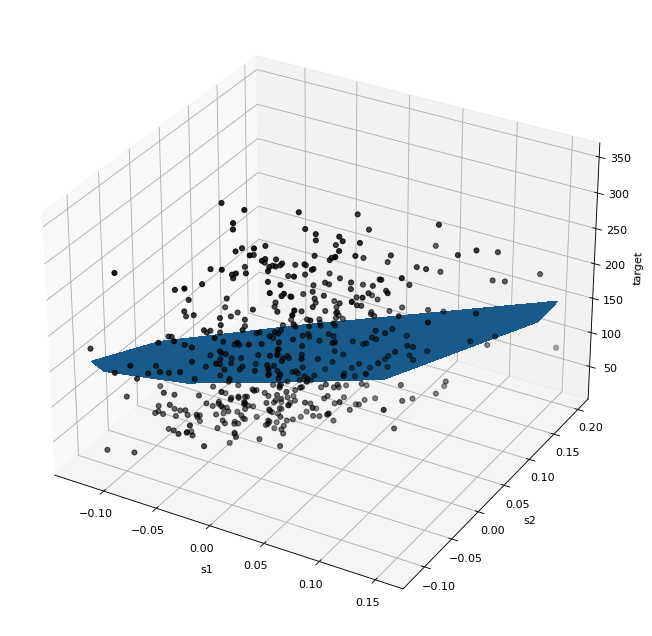

152.13348416289594 [0. 0.]
5929.884896910383
65.76457279744477
0.0


In [546]:
from sklearn.linear_model import LassoLars, LassoLarsCV, LassoLarsIC

X = df[['s1', 's2']]
y = df.target

lars = LassoLars(normalize=False)

lars.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], lars.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(lars.intercept_, lars.coef_)
print(mean_squared_error(y, lars.predict(X)))
print(mean_absolute_error(y, lars.predict(X)))
print(r2_score(y, lars.predict(X)))

### 1.8.2: LassoLarsCV

LassoLarsCV реализация LassoLars с кросс-валидацией.


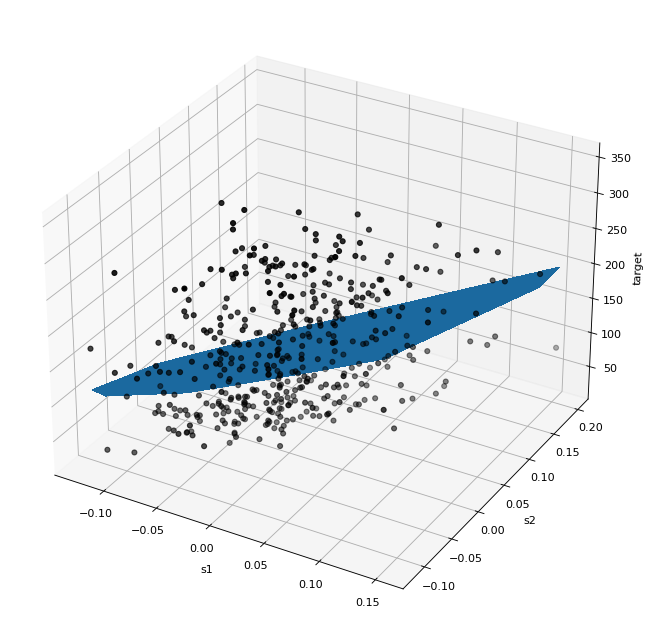

152.13348416289594 [320.06808718   0.        ]
5664.53193031968
63.82417290242349
0.044748417752418446


In [547]:
lars = LassoLarsCV(normalize=False)

lars.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], lars.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(lars.intercept_, lars.coef_)
print(mean_squared_error(y, lars.predict(X)))
print(mean_absolute_error(y, lars.predict(X)))
print(r2_score(y, lars.predict(X)))

### 1.8.3: LassoLarsIC

LassoLarsIC реализация LassoLars с оптимизацией, однако построение оптимального решения опирается на определенный критерий, подробнее выше.

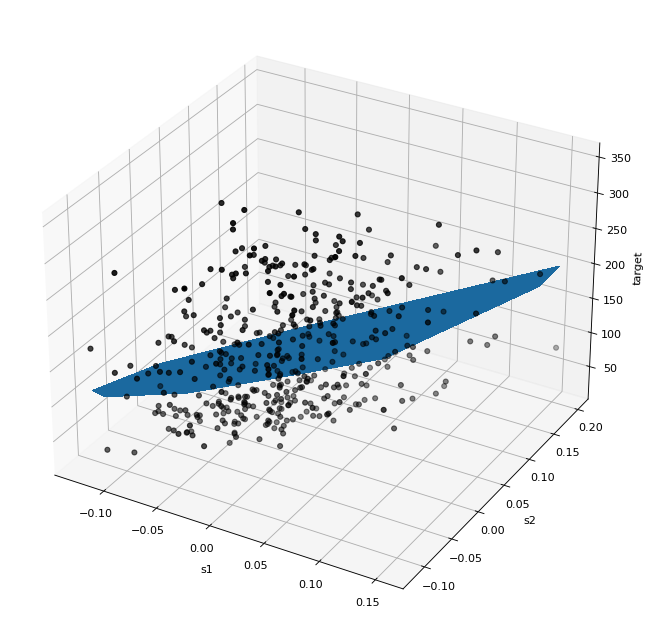

152.13348416289594 [329.54671396   0.        ]
5663.740741565264
63.791928438063664
0.04488184171733023


In [548]:
lars = LassoLarsIC(normalize=False)

lars.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], lars.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(lars.intercept_, lars.coef_)
print(mean_squared_error(y, lars.predict(X)))
print(mean_absolute_error(y, lars.predict(X)))
print(r2_score(y, lars.predict(X)))

## 1.9*: Orthogonal Matching Pursuit (OMP)

Описание метода: https://en.wikipedia.org/wiki/Matching_pursuit

Описание параметров:
1. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.OrthogonalMatchingPursuit.html
2. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.OrthogonalMatchingPursuitCV.html

### 1.9.1: OrthogonalMatchingPursuit

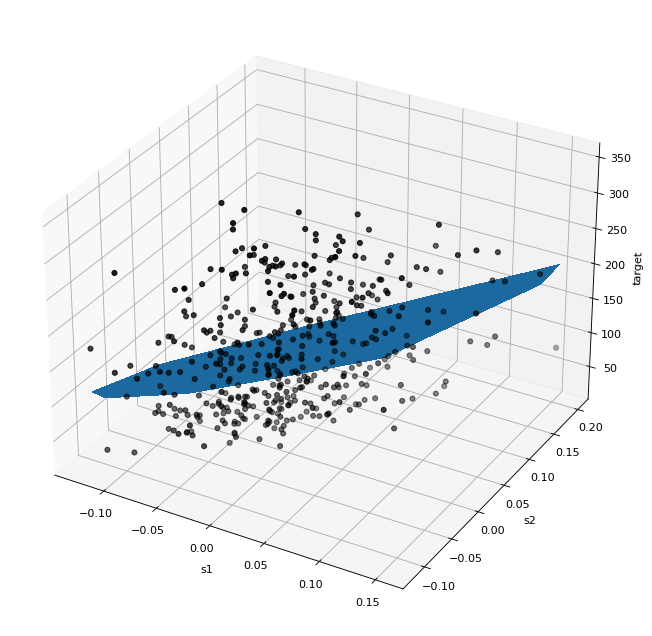

152.13348416289594 [343.25445189   0.        ]
5663.315623739354
63.747118529340035
0.04495353245556555


In [776]:
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV


X = df[['s1', 's2']]
y = df.target

omp = OrthogonalMatchingPursuit(normalize=False)

omp.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], omp.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(omp.intercept_, omp.coef_)
print(mean_squared_error(y, omp.predict(X)))
print(mean_absolute_error(y, omp.predict(X)))
print(r2_score(y, omp.predict(X)))

### 1.9.2: OrthogonalMatchingPursuitCV

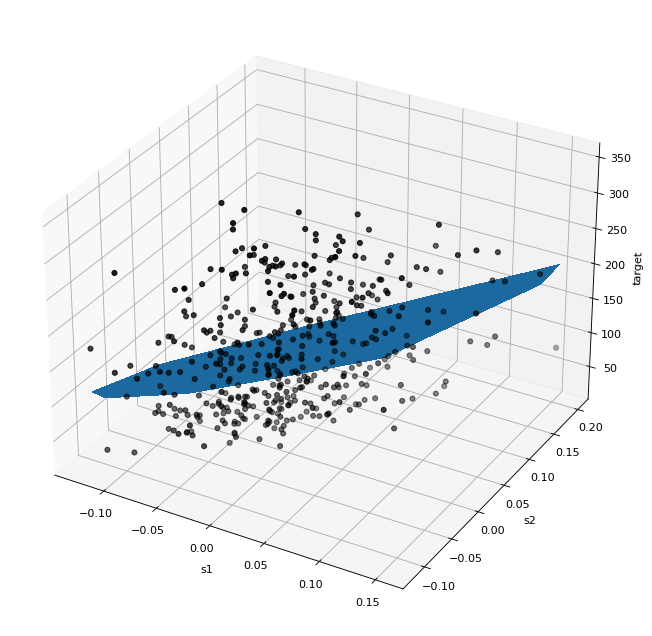

152.13348416289594 [343.25445189   0.        ]
5663.315623739354
63.747118529340035
0.04495353245556555


In [777]:
omp = OrthogonalMatchingPursuitCV(normalize=False)

omp.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], omp.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(omp.intercept_, omp.coef_)
print(mean_squared_error(y, omp.predict(X)))
print(mean_absolute_error(y, omp.predict(X)))
print(r2_score(y, omp.predict(X)))

## 1.10: Байесовский подход

Байесовская линейная регрессия — это подход в линейной регрессии, в котором статистический анализ проводится в контексте байесовского вывода: когда регрессионная модель имеет ошибки, имеющие нормальное распределение, и, если принимается определённая форма априорного распределения, доступны явные результаты для апостериорных распределений вероятностей параметров модели.

### 1.10.1: Байесовский подход с l2 (Ридж)

Параметры модели более подробно описанны тут:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html

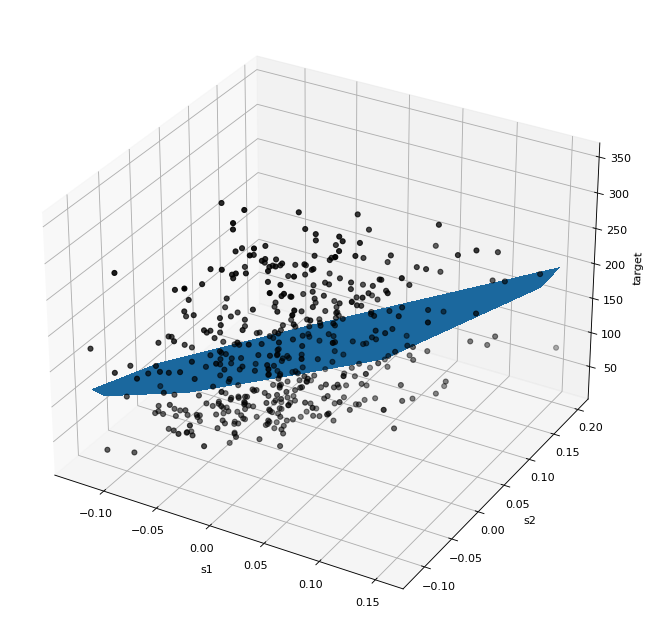

152.13348416289594 [323.56597773  -7.71105216]
5664.035982034191
63.82815045248467
0.044832053150762774


In [778]:
from sklearn.linear_model import BayesianRidge, ARDRegression

X = df[['s1', 's2']]
y = df.target

bayes = BayesianRidge()

bayes.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], bayes.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(bayes.intercept_, bayes.coef_)
print(mean_squared_error(y, bayes.predict(X)))
print(mean_absolute_error(y, bayes.predict(X)))
print(r2_score(y, bayes.predict(X)))

### 1.10.2: Автоматическое определение релевантности — ARD

Данный подход очень хорошо описан на этой статье (https://habr.com/ru/post/313566/), а ниже приведен хороший пример из этой статьи.

Более подробно про параметры можно почитать тут: 

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html

In [794]:
from sklearn.linear_model import ARDRegression

N = 50

# данные о магазинах (в данном примере случайные)
X = np.random.random(size=(N,N)) * 10 + 1

# реальные коэффициенты [1 2 3 4 5 6 7 8 0 0 ... 0]
w = np.zeros(N)
w[:8] = np.arange(8) + 1

# добавим случайную ошибку
e = np.random.normal(0, 1, size=N)

# данные о продажах
Y = np.dot(X, w) + e

ard = ARDRegression()
ard.fit(X, Y)

print(ard.coef_)

[ 1.14180383e+00  1.99657818e+00  2.97410948e+00  3.88527676e+00
  5.01016805e+00  5.93900629e+00  6.99904185e+00  7.89972640e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.31743014e-01  0.00000000e+00 -1.04386551e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.68924494e-03
  0.00000000e+00  0.00000000e+00  6.16241697e-02  0.00000000e+00
  2.44101352e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  9.21575800e-02  1.75818724e-01  0.00000000e+00  0.00000000e+00
  8.68429325e-02 -1.32907888e-01  0.00000000e+00  8.55504293e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.63148226e-02
  0.00000000e+00  7.94263524e-02  5.11039186e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


Протестируем также на наших данных:

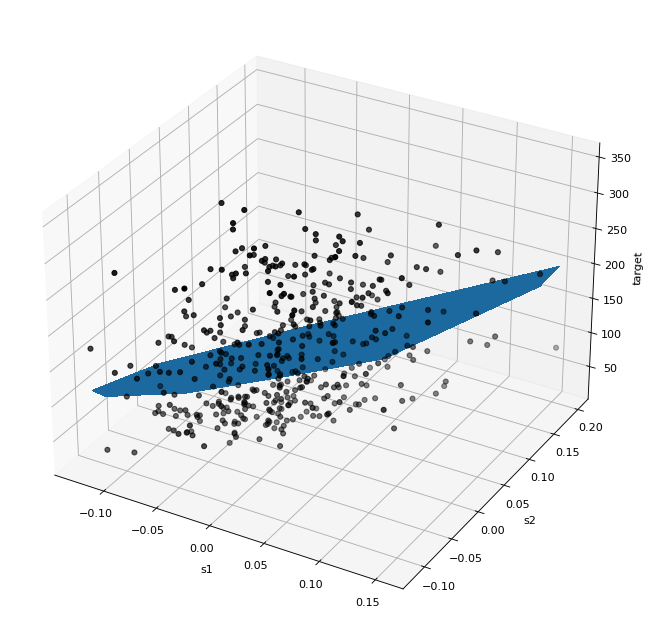

152.13348416289594 [ 3.26718524e+02 -4.02612959e-04]
5663.934238931977
63.80155022501769
0.04484921083661708


In [792]:
X = df[['s1', 's2']]
y = df.target

ard = ARDRegression()

ard.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], ard.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(ard.intercept_, ard.coef_)
print(mean_squared_error(y, ard.predict(X)))
print(mean_absolute_error(y, ard.predict(X)))
print(r2_score(y, ard.predict(X)))

## 1.11: Логистическая регрессия

Логистическая регрессия или логит-модель — статистическая модель, используемая для прогнозирования вероятности возникновения некоторого события путём его сравнения с логистической кривой.
Обычно логистическая модель используется для бинарной классификации, однако нынешние реализации позволяют решать задачи мультиклассовой классификации и содержат различные методы регуляризации.

### 1.11.1: Логистическая регрессия без кросс-валидации

Вернемся к задаче классификации видов ириса.

Параметры модели:
1. penalty - параметр отвечающий за регуляризацию (l1, l2, elnet)
2. copy_X - Если True, X будет скопирован; в противном случае он может быть перезаписан.
3. max_iter - Максимальное число итераций для алгоритма градиентного спуска.
4. tol - Шаг градиентного спуска.
5. n_jobs - Количество ядер, на которых можно проводить вычисления с целью оптимизации.
6. А так же много других параметров влияющих на способ построения модели: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [795]:
from sklearn.linear_model import LogisticRegression

X = df_iris.iloc[:, :-1]
y = df_iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

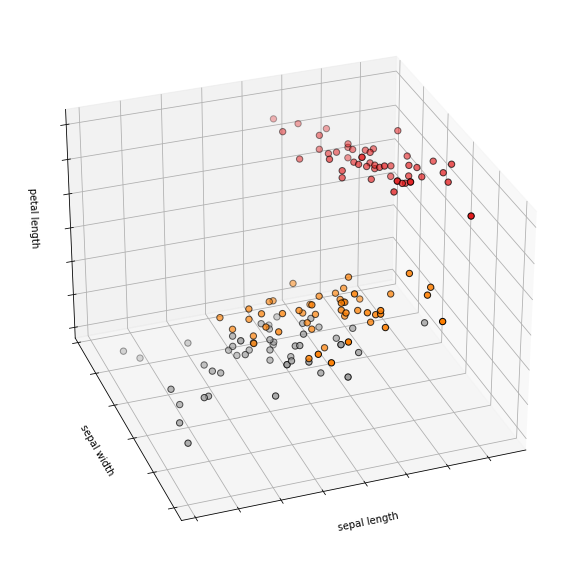

In [796]:
fig = plt.figure(1, figsize=(10, 30))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

ax.scatter(
    df_iris.iloc[:, 0],
    df_iris.iloc[:, 1],
    df_iris.iloc[:, 2],
    c=df_iris.target,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

ax.set_xlabel("sepal length")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("sepal width")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("petal length")
ax.zaxis.set_ticklabels([])

plt.show()

Решим задачу без регуляризации

In [810]:
log = LogisticRegression(max_iter=1000, penalty='none')

log.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty='none')

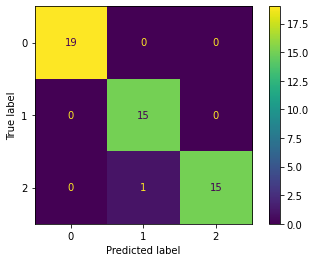

In [811]:
y_pred = log.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

Модель справилась с задачей почти со 100% точностью, однако попробуем добавить регуляризацию:

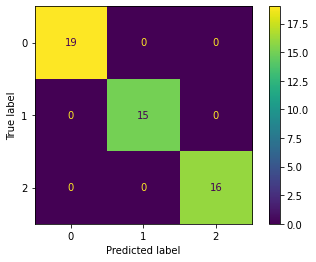

In [809]:
log = LogisticRegression(max_iter=1000, penalty='l2')

log.fit(X_train, y_train)

y_pred = log.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

Теперь задача решена на 100%.

### 1.12.2: Логистическая регрессия с кросс-валидацией

Более подробное описание метода: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html

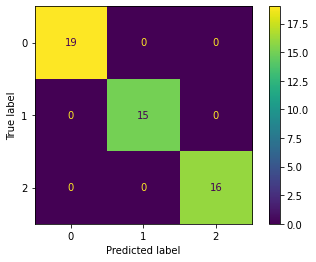

In [808]:
from sklearn.linear_model import LogisticRegressionCV

log = LogisticRegressionCV(max_iter=1000, penalty='l2')

log.fit(X_train, y_train)

y_pred = log.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

## 1.12*: GLM

Более подробно о GLM, https://ru.wikipedia.org/wiki/Обобщённая_линейная_модель.
Подробнее о методах ниже:
1. TweedieRegressor - https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html#sphx-glr-auto-examples-linear-model-plot-tweedie-regression-insurance-claims-py
2. PoissonRegressor - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html
3. GammaRegressor - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.GammaRegressor.html

In [ ]:
from sklearn.linear_model import TweedieRegressor, PoissonRegressor, GammaRegressor

### 1.12.1: TweedieRegressor

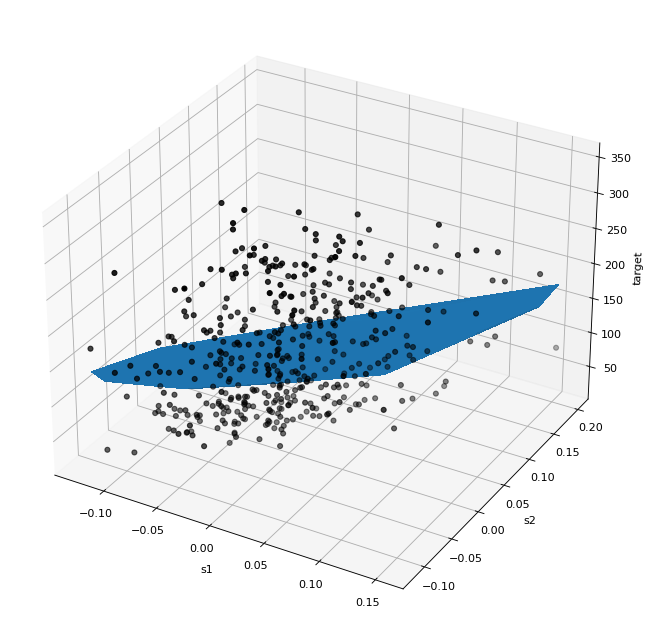

5.021182150427968 [1.8199591  0.12209725]
5675.831688626505
63.886016763890424
0.042842856598489076


In [968]:
X = df[['s1', 's2']]
y = df.target

twe = TweedieRegressor(power=0.4)

twe.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], lars.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(twe.intercept_, twe.coef_)
print(mean_squared_error(y, twe.predict(X)))
print(mean_absolute_error(y, twe.predict(X)))
print(r2_score(y, twe.predict(X)))

### 1.12.2: PoissonRegressor

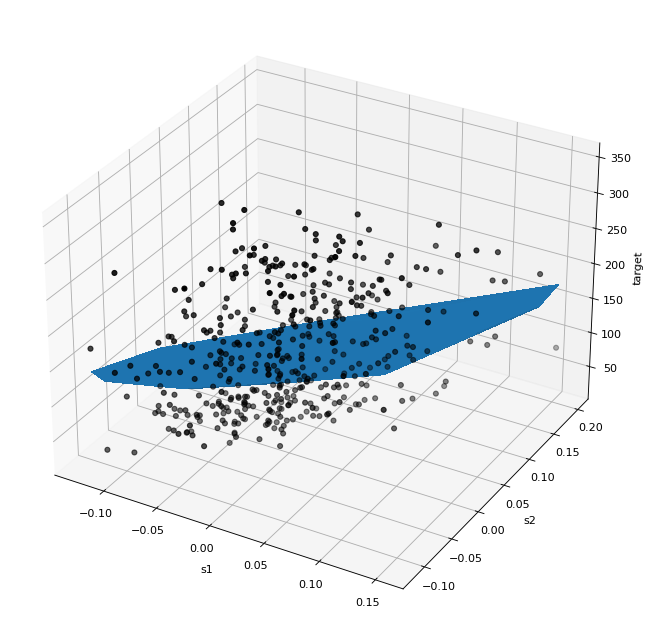

5.023972609155618 [0.49362821 0.3591736 ]
5780.020521352293
64.82875136822058
0.0252727292626157


In [970]:
X = df[['s1', 's2']]
y = df.target

pois = PoissonRegressor()

pois.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], pois.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(pois.intercept_, pois.coef_)
print(mean_squared_error(y, pois.predict(X)))
print(mean_absolute_error(y, pois.predict(X)))
print(r2_score(y, pois.predict(X)))

### 1.12.3: GammaRegressor

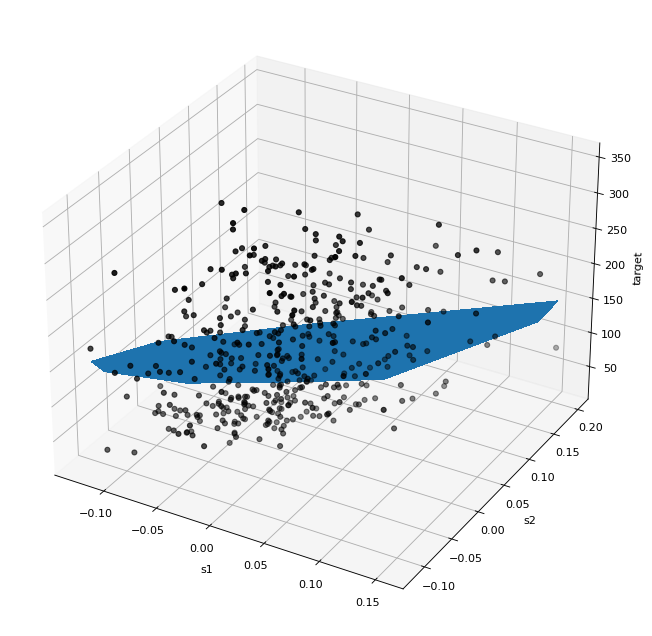

5.024758320749398 [0.00508289 0.00417265]
5927.878669140827
65.75282222323816
0.00033832490924090575


In [645]:
X = df[['s1', 's2']]
y = df.target

lars = GammaRegressor()

lars.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], lars.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(lars.intercept_, lars.coef_)
print(mean_squared_error(y, lars.predict(X)))
print(mean_absolute_error(y, lars.predict(X)))
print(r2_score(y, lars.predict(X)))

## 1.13: Стохастический градиентный спуск — SGD

Стохастический градиентный спуск — достаточно трудный, но очень эффективный подход для подбора линейных моделей. Это особенно полезно, когда количество образцов (и количество функций) очень велико. Более подробно тут: https://ru.wikipedia.org/wiki/Стохастический_градиентный_спуск

### 1.13.1: Регрессия

Параметры модели:

1. loss - Используемая функция потерь. Возможные значения ‘squared_error’, ‘huber’, ‘epsilon_insensitive’, или ‘squared_epsilon_insensitive’
1. penalty - Регуляризация {‘l2’, ‘l1’, ‘elasticnet’, None}, default=’l2’
1. alpha - Константа, умножающая член регуляризации. Чем выше значение, тем сильнее регуляризация. Также используется для вычисления скорости обучения, когда для параметра Learning_rate установлено значение «Оптимальный».
3. fit_intercept - Рассчитывать ли intercept для этой модели. Если установлено значение False, то ожидается, что данные будут центрированы.
5. max_iter - Максимальное число итераций для алгоритма градиентного спуска.
6. А так же другие параметры: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html


In [648]:
from sklearn.linear_model import SGDClassifier, SGDRegressor

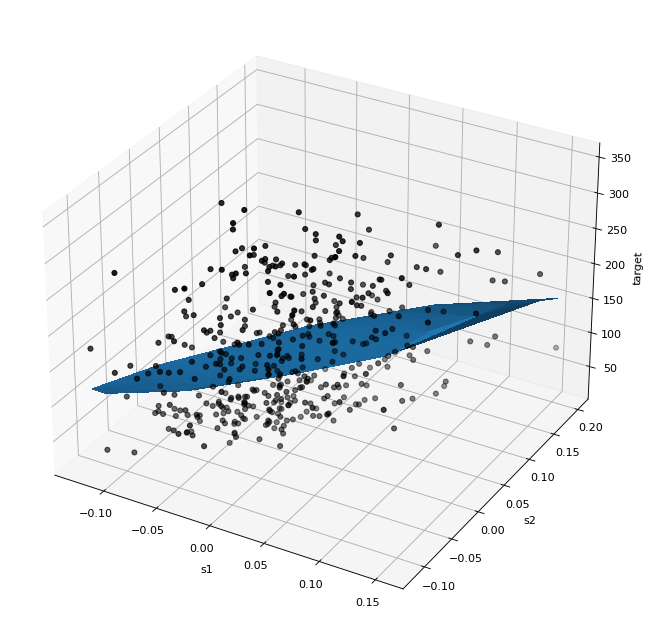

[152.11578315] [105.92335747  79.48419911]
5737.8574981253
64.51135123374425
0.03238298923561467


In [812]:
X = df[['s1', 's2']]
y = df.target

sgd = SGDRegressor()

sgd.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], lars.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(sgd.intercept_, sgd.coef_)
print(mean_squared_error(y, sgd.predict(X)))
print(mean_absolute_error(y, sgd.predict(X)))
print(r2_score(y, sgd.predict(X)))

### 1.13.2: Классификация

Больше параметров о модели: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [966]:
X = df_iris.iloc[:, :-1]
y = df_iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

SGD = SGDClassifier(max_iter=100, random_state=20)

SGD.fit(X_train, y_train)

SGDClassifier(max_iter=100, random_state=20)

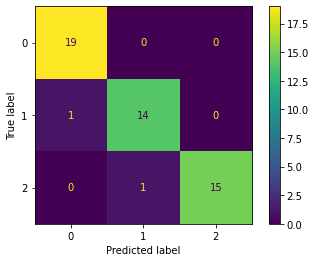

In [967]:
y_pred = SGD.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

### Замечание

Дело в том, что SGD более сложный алгоритм, а значит он требует более детальной настройки и подбора параметров, для достижения высокого результата. Такими же алгоритмами будут перцептрон и пассивно-агрессивные методы.

## 1.14 Перцептрон

Простой алгоритм используемый для классификации, представляет собой простой пример нейронной сети: https://ru.wikipedia.org/wiki/Перцептрон. Более подробно нейронные сети будут разобраны в другом блоке.

Подробнее: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html

In [930]:
from sklearn.linear_model import Perceptron

Вернемся к задаче с ирисами.

In [964]:
X = df_iris.iloc[:, :-1]
y = df_iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

prc = Perceptron(max_iter=1000, random_state=20)

prc.fit(X_train, y_train)

Perceptron(random_state=20)

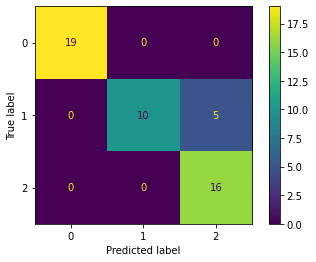

In [965]:
y_pred = prc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

## 1.15 Пассивно-агрессивные алгоритмы

Пассивно-агрессивный регрессор и классификатор относится к категории алгоритмов онлайн-обучения в машинном обучении. Он работает, пассивно реагируя на правильные классификации и агрессивно реагируя на любые просчеты. 

Пассивно-агрессивный регрессор и классификатор – это алгоритм онлайн-обучения, в котором вы обучаете систему постепенно, загружая ее экземпляры последовательно, отдельно или небольшими группами, называемыми мини-партиями.

Подробнее про каждый алгоритм:
1. PassiveAggressiveClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PassiveAggressiveClassifier.html
2. PassiveAggressiveRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PassiveAggressiveRegressor.html

### 1.15.1: Регрессия

In [858]:
from sklearn.linear_model import  PassiveAggressiveClassifier, PassiveAggressiveRegressor

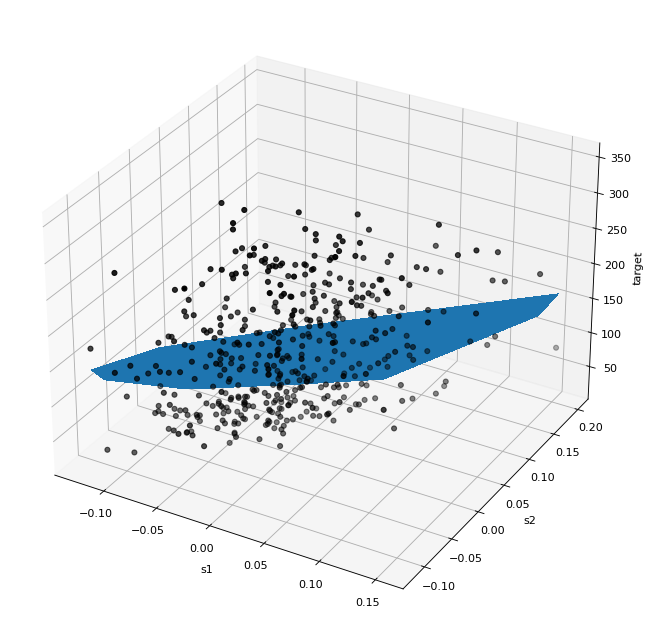

[149.] [42.74411251 35.18374548]
5841.489243588868
64.90414701116558
0.014906807612331874


In [961]:
X = df[['s1', 's2']]
y = df.target

pac = PassiveAggressiveRegressor()

pac.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], pac.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(pac.intercept_, pac.coef_)
print(mean_squared_error(y, pac.predict(X)))
print(mean_absolute_error(y, pac.predict(X)))
print(r2_score(y, pac.predict(X)))

### 1.15.2: Классификация

In [962]:
X = df_iris.iloc[:, :-1]
y = df_iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

pac = PassiveAggressiveClassifier(random_state=10)

pac.fit(X_train, y_train)

PassiveAggressiveClassifier(random_state=10)

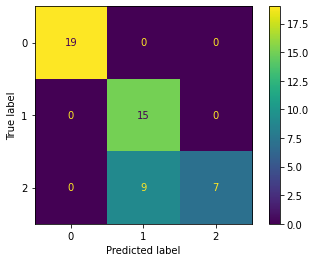

In [963]:
y_pred = pac.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

## 1.16 Регрессия устойчивости: выбросы и ошибки моделирования

Устойчивая регрессия направлена на то, чтобы соответствовать модели регрессии при наличии искаженных данных: либо выбросов, либо ошибки в модели.
Рассмотрим некоторые подходы, создав набор данных с выбросами.

In [885]:
from sklearn.linear_model import HuberRegressor, RANSACRegressor, TheilSenRegressor

from sklearn.datasets import make_regression

# Generate toy data.
rng = np.random.RandomState(0)
X, y = make_regression(
    n_samples=20, n_features=1, random_state=0, noise=4.0, bias=100.0
)

# Add four strong outliers to the dataset.
X_outliers = rng.normal(0, 0.5, size=(4, 1))
y_outliers = rng.normal(0, 2.0, size=4)
X_outliers[:2, :] += X.max() + X.mean() / 4.0
X_outliers[2:, :] += X.min() - X.mean() / 4.0
y_outliers[:2] += y.min() - y.mean() / 4.0
y_outliers[2:] += y.max() + y.mean() / 4.0

X = np.vstack((X, X_outliers))
y = np.concatenate((y, y_outliers))

Компромиссы: какой оценщик?
Scikit-learn предоставляет 3 надежных средства оценки регрессии: RANSAC , Theil Sen и HuberRegressor.
HuberRegressor должен быть быстрее, чем RANSAC и Theil Sen, если количество выборок не очень велико, т.е.n_samples>>n_features. Это связано с тем, что RANSAC и Theil Sen подходят для меньших подмножеств данных. Однако и Theil Sen, и RANSAC вряд ли будут такими же надежными, как HuberRegressor для параметров по умолчанию.
RANSAC быстрее, чем Theil Sen, и намного лучше масштабируется с количеством образцов.
RANSAC лучше справляется с большими выбросами в направлении y (наиболее распространенная ситуация).
Theil Sen лучше справляется с выбросами среднего размера в направлении X, но это свойство исчезнет в настройках с высокой размерностью.
В случае сомнений используйте RANSAC.


Более подробно о каждой модели:
1. HuberRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html
2. RANSACRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html
3. TheilSenRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.TheilSenRegressor.html



### 1.16.1: HuberRegressor

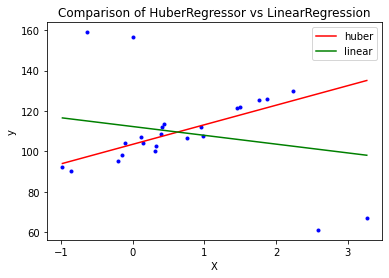

103.4859278339319 [9.68529274]
674.7447811304742
13.603639934604168


In [901]:
plt.plot(X, y, "b.")
x = np.linspace(X.min(), X.max(), 7)

huber = HuberRegressor(alpha=0.0)
huber.fit(X, y)
coef_ = huber.coef_ * x + huber.intercept_
plt.plot(x, coef_,  "r-", label="huber")

regr = LinearRegression()
regr.fit(X, y)
coef_ridge = regr.coef_
coef_ = regr.coef_ * x + regr.intercept_
plt.plot(x, coef_, "g-", label="linear")

plt.title("Comparison of HuberRegressor vs LinearRegression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

print(huber.intercept_, huber.coef_)
print(mean_squared_error(y, huber.predict(X)))
print(mean_absolute_error(y, huber.predict(X)))

### 1.16.2: RANSACRegressor

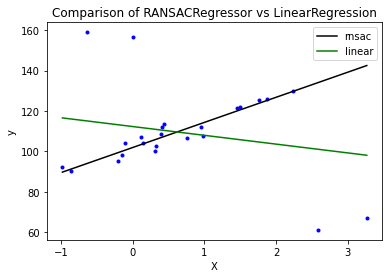

101.89622505659258 [12.44002424]
771.614235194325
13.582951594654448


In [899]:
plt.plot(X, y, "b.")

x = np.linspace(X.min(), X.max(), 7)

rnsac = RANSACRegressor()
rnsac.fit(X, y)
coef_ = rnsac.estimator_.coef_ * x + rnsac.estimator_.intercept_
plt.plot(x, coef_,  "black", label="rnsac")

regr = LinearRegression()
regr.fit(X, y)
coef_ridge = regr.coef_
coef_ = regr.coef_ * x + regr.intercept_
plt.plot(x, coef_, "g-", label="linear")

plt.title("Comparison of RANSACRegressor vs LinearRegression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

print(rnsac.estimator_.intercept_, rnsac.estimator_.coef_)
print(mean_squared_error(y, rnsac.predict(X)))
print(mean_absolute_error(y, rnsac.predict(X)))

### 1.16.3: TheilSenRegressor

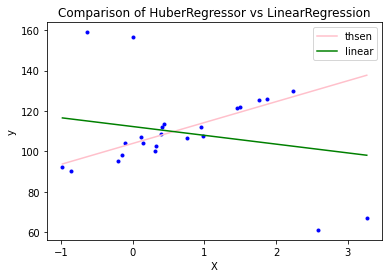

103.90784025218335 [10.35397088]
698.863926860101
13.538911760947036


In [900]:
plt.plot(X, y, "b.")

x = np.linspace(X.min(), X.max(), 7)

thsen = TheilSenRegressor()
thsen.fit(X, y)
coef_ = thsen.coef_ * x + thsen.intercept_
plt.plot(x, coef_,  "pink", label="thsen")

regr = LinearRegression()
regr.fit(X, y)
coef_ridge = regr.coef_
coef_ = regr.coef_ * x + regr.intercept_
plt.plot(x, coef_, "g-", label="linear")

plt.title("Comparison of HuberRegressor vs LinearRegression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

print(thsen.intercept_, thsen.coef_)
print(mean_squared_error(y, thsen.predict(X)))
print(mean_absolute_error(y, thsen.predict(X)))

## 1.17 Квантильная регрессия 

Этот метод применяется, когда в данных присутствуют сильные искажения, часто встречаются выпадающие значения и случайные ошибки. Другими словами, если среднее значение, с которым работает линейная регрессия, неточно отражает взаимосвязь между переменными. В этих случаях квантильная регрессия позволяет ввести в расчеты целевую погрешность, или задать квантили — значения, которое результирующие переменные не будут превышать.

In [860]:
from sklearn.linear_model import QuantileRegressor

Параметры модели:

1. quantile -- Квантиль, который модель пытается предсказать. Он должен быть строго между 0 и 1. Если 0,5 (по умолчанию), модель предсказывает 50%-й квантиль, то есть медиану.
2. alpha - Константа, умножающая член L1, контролирующая силу регуляризации в [0, inf).
3. fit_intercept - Рассчитывать ли intercept для этой модели. Если установлено значение False, то ожидается, что данные будут центрированы.
4. А так же другие параметры: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor
    

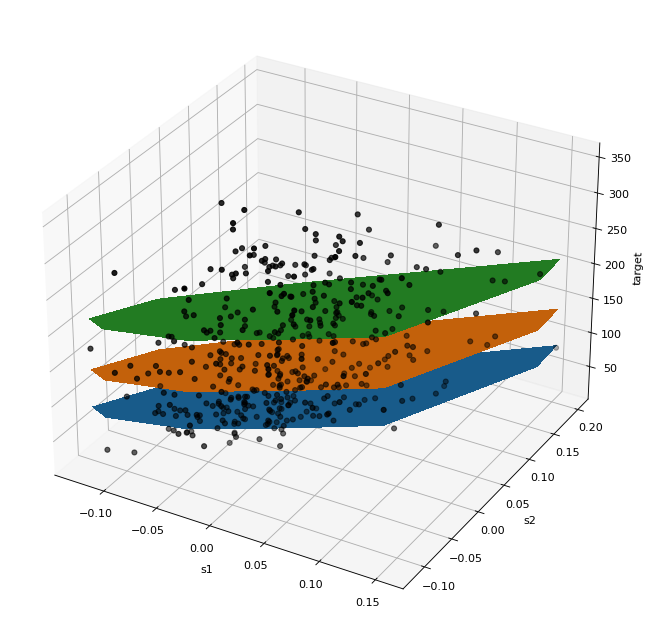

76.95701357531239
65.04298642531708
84.29185195392185


In [869]:
X = df[['s1', 's2']]
y = df.target

p1 = QuantileRegressor(quantile=0.25)
p2 = QuantileRegressor(quantile=0.5)
p3 = QuantileRegressor(quantile=0.75)

p1.fit(X, y)
p2.fit(X, y)
p3.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], p1.predict(X), linewidth=0, antialiased=False)
ax.plot_trisurf(X['s1'], X['s2'], p2.predict(X), linewidth=0, antialiased=False)
ax.plot_trisurf(X['s1'], X['s2'], p3.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(mean_absolute_error(y, p1.predict(X)))
print(mean_absolute_error(y, p2.predict(X)))
print(mean_absolute_error(y, p3.predict(X)))

## 1.18: Полиномиальная регрессия: расширение линейных моделей с помощью базисных функций 

Один из распространенных паттернов машинного обучения — использование линейных моделей, обученных нелинейным функциям данных. Такой подход обеспечивает в целом высокую производительность линейных методов, позволяя им приспосабливать гораздо более широкий диапазон данных.

Например, простая линейная регрессия может быть расширена путем построения полиномиальных функций из коэффициентов.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

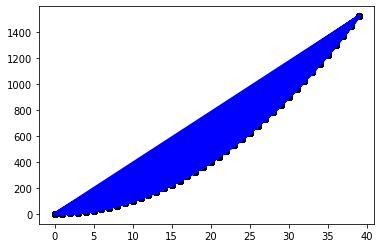

In [841]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

X = kx_df.x
y = kx_df['y^2']

model = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', LinearRegression())])


model.fit(X.values.reshape(-1, 1), y)

plt.scatter(kx_df.x, kx_df['y^2'], color="black")
plt.plot(kx_df.x, model.predict(X.values.reshape(-1, 1)), color="blue", linewidth=3)
plt.show()

In [843]:
print(model.named_steps['linear'].intercept_, model.named_steps['linear'].coef_)
print(mean_squared_error(y, model.predict(X.values.reshape(-1, 1))))
print(mean_absolute_error(y, model.predict(X.values.reshape(-1, 1))))
print(r2_score(y, model.predict(X.values.reshape(-1, 1))))

6.59383658785373e-12 [0.00000000e+00 1.33119210e-13 1.00000000e+00 1.65056904e-15]
2.1254073286755196e-23
4.114899088136781e-12
1.0


Использовав данный подход удалось достичь R2 равного 1, попробуем данный подход на задаче с диабетом на двух кореллирующих переменных.

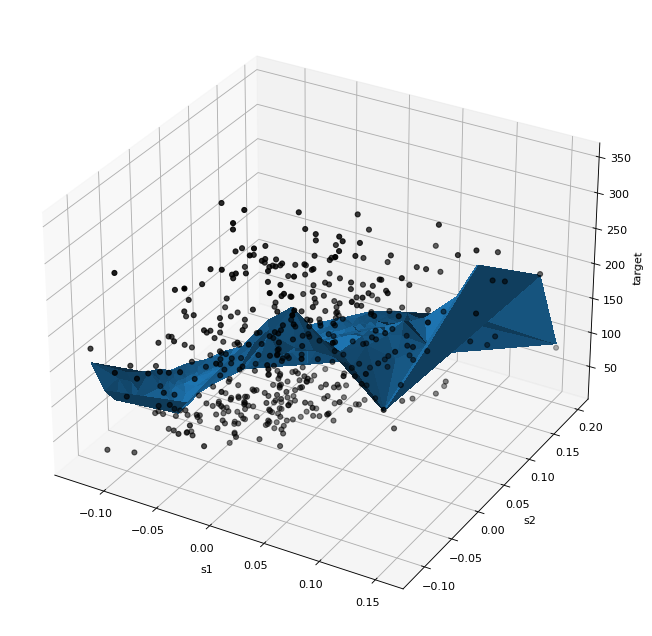

150.25901821863636 [ 0.00000000e+00  4.93086053e+02 -4.00724745e+00  2.06653767e+04
 -4.27425008e+04  2.04371759e+04 -1.14029492e+05  3.33506337e+05
 -4.36883560e+05  1.77957271e+05 -1.00637546e+07  3.90364752e+07
 -5.55016854e+07  3.56605015e+07 -8.97770994e+06  7.97849130e+07
 -4.80096724e+08  1.15290992e+09 -1.33618922e+09  7.43667277e+08
 -1.58927946e+08]
5493.391252517715
62.21723693758672
0.07360912597478775


In [857]:
X = df[['s1', 's2']]
y = df.target

model = Pipeline([('poly', PolynomialFeatures(degree=5)), ('linear', LinearRegression())])

model.fit(X, y)

ax = plt.figure(figsize=(10, 30), dpi=80).add_subplot(projection='3d')
ax.scatter(X['s1'], X['s2'], y, color="black")


ax.plot_trisurf(X['s1'], X['s2'], model.predict(X), linewidth=0, antialiased=False)

ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('target')

plt.show()

print(model.named_steps['linear'].intercept_, model.named_steps['linear'].coef_)
print(mean_squared_error(y, model.predict(X)))
print(mean_absolute_error(y, model.predict(X)))
print(r2_score(y, model.predict(X)))

Однако стоит учитывать высокую предрасположенность к переобучению данной модели!